In [2]:
#utils

from utils import plotfm,make_gif,count_parameters

# Data Loading

In [3]:
FILE_INPUT = './input/BRCA.list'
SURV_PATH = './clinical_PANCAN_patient_with_followup.tsv'
TYPE = 'BRCA'

## Based on a script found in the Subtype Gan Repository, we load the files related to BRCA OMICS data.

In [4]:
from load_data import load_data,extract_hormone_labels
raw_data, last_file = load_data(SURV_PATH,FILE_INPUT,TYPE) #last file is used to retrieve list of patients

./fea/BRCA/meth.fea loaded
./fea/BRCA/rna.fea loaded
./fea/BRCA/CN.fea loaded
./fea/BRCA/miRNA.fea loaded


## We found how to access the clinical data, publicly available but not shared in the SubType Gan repository. Then, we used a lot Genomic Data Commons data dictionnary (https://docs.gdc.cancer.gov/Data_Dictionary/viewer/) as well as other tools to find the columns corresponding to estrogen, progesteron and HR responses. We implemented a function to extract those labels from the clinical data file.

In [5]:
table = extract_hormone_labels(last_file,SURV_PATH)
PR = table['PR']
ER = table['ER']
HR = table['HR']
table

C:\Users\ilias\OneDrive\Cours\Semestre MVAA\biostats\load_data.py:70: DtypeWarning: Columns (127,153,166) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(SURV_PATH, header=0, sep='\t',


,PR,ER,HR
TCGA-D8-A1XJ,Positive,Positive,Positive
TCGA-EW-A6SA,Negative,Positive,Negative
TCGA-D8-A27H,Negative,Negative,Negative
TCGA-E9-A247,[Not Evaluated],[Not Evaluated],[Not Evaluated]
TCGA-AC-A2FG,Negative,Positive,[Not Evaluated]
...,...,...,...
TCGA-A2-A0D0,Negative,Negative,Negative
TCGA-3C-AALK,Positive,Positive,Positive
TCGA-AO-A1KS,Positive,Positive,Equivocal
TCGA-EW-A1OW,Negative,Negative,Negative


## Preparing data loader for pytorch

In [6]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
data_gpu = [i.to(device) for i in raw_data] #our dataset in GPU



class MedData(Dataset):
    def __init__(self, dataset,device):
        self.dataset = dataset
        self.device = device
    def __len__(self):
        return len(self.dataset[0])

    def __getitem__(self, i):
        return([column[i].to(device) for column in self.dataset])
    
batch_size = 64
data = MedData(data_gpu,device)
loader = DataLoader(data, batch_size=batch_size, shuffle=True)

# Models implementation : Subtype Gan and Vanilla VAE

## We implemented common Encoder and Decoder layers in layers.py, that will be used for every models. Because discriminator is used at both steps (minimization, maximization), subtype gan has its own decoder class which is exactly the same as the Decoder class except it includes a small discriminator module.

In [7]:
from layers import Encoder, Decoder, DecoderDisc
import torch
import torch.nn as nn
import torch.nn.functional as F

class SubtypeGAN(nn.Module):
    def __init__(self, n=4, latent_dim=2, shape = [3139, 3217, 3105, 383],weight = [0.25, 0.25, 0.25, 0.25],sample=True): 
        super(SubtypeGAN, self).__init__()
        self.latent_dim = latent_dim
        self.n = n
        self.sample = sample
        self.shape = shape
        self.weights = weights
        self.encoder = Encoder(self.latent_dim,self.n,self.shape,self.weights,self.sample)
        self.decoder = DecoderDisc(self.latent_dim,self.n,self.shape,self.weights)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        #self.disc_optimizer = optim.Adam(self.disc.parameters()) #à faire : un adam juste sur les param du disc ?
    def forward(self,x):
        x,z_mean,z_log_var = self.encoder(x)
        x = self.decoder(x)
        
        return(x)
    


    
class VAE(nn.Module):
    def __init__(self, n=4, latent_dim=2, shape = [3139, 3217, 3105, 383],weight = [0.25, 0.25, 0.25, 0.25], sample=True): 
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.n = n
        self.sample = sample
        self.shape = shape
        self.weights = weights
        self.encoder = Encoder(self.latent_dim,self.n,self.shape,self.weights,self.sample)
        self.decoder = Decoder(self.latent_dim,self.n,self.shape,self.weights)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        #self.disc_optimizer = optim.Adam(self.disc.parameters()) #à faire : un adam juste sur les param du disc ?
    def forward(self,x):
        x,z_mu,z_log_var = self.encoder(x)
        x = self.decoder(x)
        return(x,z_mu,z_log_var)



In [8]:
from tqdm import tqdm
import numpy as np 

latent_dim = 2
n = len(raw_data) #number of features
n_epochs = 150

NOISE = torch.randn(len(raw_data[0]),latent_dim).to(device) #for plots

# Training SubType GAN

In [9]:
weights = [0.25, 0.25, 0.25, 0.25] #same as [0.3, 0.1, 0.1, 0.5] for latent dim 2
shape = []
for i in range(n):
    shape.append(data_gpu[i].shape[1])

weight = [0.25, 0.25, 0.25, 0.25]
mse_weights = [0.25, 0.25, 0.25, 0.25]
model = SubtypeGAN(n,latent_dim,shape,weight,sample=True)
model = model.to(device) 


xavier = True
lr = 0.001 #keras default
disc_lr = 0.001
disc_w = 1e-4 #disc weight for minimization only (contrary to original impl.)
loss_weights = []
for i in range(model.n):
            loss_weights.append((1 - disc_w) * weight[i]) #loss weight for mse is proportional to importance in the latent space construction here, but in our basic setting we set equal weights
loss_weights.append(disc_w)

loss_weights[-1] = disc_w

#setup parameters of each model for optimizers
in_disc = ['decoder.decode.4.0.weight','decoder.decode.4.0.bias','decoder.decode.4.2.weight','decoder.decode.4.2.bias'] #parameters for discriminator only, with our basic setting
gan_params = []
disc_params = []
for name, param in model.named_parameters():
    if param.requires_grad:
        if xavier:
            try:
                nn.init.xavier_normal_(param)
            except:
                pass
        if name in in_disc:
            disc_params.append(param)
            #print('added')
        else:
            gan_params.append(param)
            
optimizer = torch.optim.Adam(gan_params,lr=lr, betas=(0.9, 0.999), eps=1e-07)
optimizer_disc = torch.optim.Adam(disc_params,lr=disc_lr, betas=(0.9, 0.999), eps=1e-07)


valid = torch.ones((batch_size, 1)).to(device).type(torch.float32)
fake = torch.zeros((batch_size, 1)).to(device).type(torch.float32)
itr = tqdm(range(n_epochs))


log_file = "./subtype_gan.log"
fp = open(log_file, 'a')
for epoch in itr:
    #  Train Discriminator
    for data in iter(loader): #training DISCRIMINATOR
        batch_size_t = data[0].shape[0]
        latent_fake,_,_ = model.encoder(data) #our actual data
        latent_real = torch.tensor(np.random.normal(size=(batch_size_t,model.latent_dim))).to(model.device).type(torch.float32)
        disc_fake = model.decoder(latent_fake)[-1]
        disc_real = model.decoder(latent_real)[-1]
        
        
        # Compute binary cross-entropy loss between the discriminator output and valid labels
        loss_disc = (0.5*F.binary_cross_entropy(disc_real, valid[:batch_size_t]) + 0.5*F.binary_cross_entropy(disc_fake, fake[:batch_size_t]))
        loss_disc.backward()
        optimizer_disc.step()
        optimizer_disc.zero_grad()

    for data in iter(loader): #training generator
        batch_size_t = data[0].shape[0]
        gt = data + [valid[:batch_size_t]]
        z = model(data)
        
        
        
        
        loss = torch.tensor([0]).to(device).type(torch.float32)
        MSE = 0
        for i in range(len(gt)):
            loss+=loss_weights[i]*F.mse_loss(gt[i],z[i])
            if i!=n:
                MSE += mse_weights[i]*F.mse_loss(gt[i],z[i])
                
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    logger = str(MSE.item())+','+str(loss_disc.item())+'\n'
    fp.write(logger)
    itr.set_postfix({'losses': logger})
    
    plotfm(model,data_gpu,ER,legend = None, epoch = '- SGAN - MSE : ' + str(MSE.item())[:6] + ' - epoch ' + str(epoch),eps = NOISE,save='./sgan/'+str(epoch)+'.png')
fp.close()

100%|██████████████████████████████████| 150/150 [01:42<00:00,  1.46it/s, losses=0.4548187851905823,0.6961650848388672]


In [10]:
make_gif('./sgan/','SGAN.gif')

# Training a vanilla VAE

In [11]:
model = VAE(n,latent_dim)
model = model.to(device) 


xavier = True
lr = 0.001 #keras default
weights = [0.25, 0.25, 0.25, 0.25]
loss_weights = weights
#setup parameters of each model for optimizers
for name, param in model.named_parameters():
    if param.requires_grad:
        if xavier:
            try:
                nn.init.xavier_normal_(param)
            except:
                pass            

optimizer = torch.optim.Adam(model.parameters(),lr=lr, betas=(0.9, 0.999), eps=1e-07)


#Training
log_file = "./vae.log"
alpha = 1
fp = open(log_file, 'a')
ITR = tqdm(range(n_epochs))
for epoch in ITR:
    #  Train Discriminator

    for data in iter(loader): #training generator
        batch_size_t = data[0].shape[0]
        z,z_mu,z_log_var = model(data)
        
        kl = (-0.5*(1+z_log_var -z_mu**2- torch.exp(z_log_var)).sum(dim = 1)).mean(dim =0) 
        
        
        
        
        loss_mse = torch.tensor([0]).to(device).type(torch.float32)
        for i in range(len(data)):
            loss_mse+=loss_weights[i]*F.mse_loss(data[i],z[i])
        
        loss = loss_mse*alpha + kl
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    logger = str(loss_mse.item())+','+str(kl.item())+'\n'
    fp.write(logger)
    ITR.set_postfix({'Losses': logger})
    plotfm(model,data_gpu,ER,legend = None, epoch = '- VAE - MSE : ' + str(loss_mse.item())[:6] + ' - epoch ' + str(epoch),eps = NOISE,save='./vae/'+str(epoch)+'.png')
    
fp.close()


100%|████████████████████████████████| 150/150 [01:23<00:00,  1.80it/s, Losses=0.4603237211704254,0.009723535738885403]


In [12]:
make_gif('./vae/','VAE.gif')

# Gaussian Mixture prior VAE and SNIS FKL estimator model

In [13]:
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore")
import os

#utils for gmvae


def log_normal(x, m, v):

	const = -0.5*x.size(-1)*torch.log(2*torch.tensor(np.pi))
	log_det = -0.5*torch.sum(torch.log(v), dim = -1)
	log_exp = -0.5*torch.sum( (x - m)**2/v, dim = -1)

	log_prob = const + log_det + log_exp

	return log_prob


def log_normal_mixture(z, m, v):
	z = z.unsqueeze(1)
	log_probs = log_normal(z, m, v)

	log_prob = log_mean_exp(log_probs, 1)

	return log_prob


def log_mean_exp(x, dim):
	return log_sum_exp(x, dim) - np.log(x.size(dim))


def log_sum_exp(x, dim=0):

	max_x = torch.max(x, dim)[0]
	new_x = x - max_x.unsqueeze(dim).expand_as(x)
	return max_x + (new_x.exp().sum(dim)).log()


def sample_gaussian(m, v):

	sample = torch.randn(m.shape).to(device)
	z = m + (v**0.5)*sample
	return z

def gmm_params(means,v):

    mtp = {}
    k = means.shape[0]
    a = np.ones(k)*1.0/k

    for i in range(k):
        mu = means[i]
        cov  =  torch.diag(v[i])
        mtp[i] = cov,mu,a[i]
    return(mtp)

def log_lh_torch(mtp,X):
    return(torch.log(torch.stack([torch.exp(MultivariateNormal(loc=mtp[key][1],covariance_matrix = mtp[key][0]).log_prob(X))*mtp[key][2] for key in list(mtp.keys())]).sum(axis=0)))

In [16]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal




class GMVAE_m(nn.Module):
    def __init__(self, z_dim=100, k=5, z_pre=None, SNIS = False, z_prior = 'k_mixture', n = 4, shape = [3139, 3217, 3105, 383],weight = [0.25, 0.25, 0.25, 0.25],step=5,sample=False,device='cuda',alpha = 10):
        '''
        prior : in 'each_single', 'each_mixture', 'k_mixture'
        
        '''
        super().__init__()
        self.prior = z_prior
        self.k = k
        self.alpha = alpha
        self.device = device
        self.n = n
        self.SNIS = SNIS
        self.step = step
        self.shape = shape
        self.sample = sample
        self.weight = weight
        self.z_dim = z_dim
        self.encoder = Encoder(self.z_dim, n = 4, shape = [3139, 3217, 3105, 383],weight = [0.25, 0.25, 0.25, 0.25],sample=self.sample)
        self.decoder = Decoder(self.z_dim, n = 4, shape = [3139, 3217, 3105, 383],weight = [0.25, 0.25, 0.25, 0.25])

        # Mixture of Gaussians prior
        #self.z_pre = torch.nn.Parameter(torch.randn(1, 2 * self.k, self.z_dim)
         #                               / np.sqrt(self.k * self.z_dim))
        if z_pre is None:
            self.z_pre =  torch.nn.Parameter(torch.stack([10*torch.ones(self.z_dim),13*torch.ones(self.z_dim),1*torch.ones(self.z_dim),1*torch.ones(self.z_dim)]).unsqueeze(0),requires_grad=False)
        else:
            self.z_pre = z_pre
        # Uniform weighting
        self.pi = torch.nn.Parameter(torch.ones(k) / k, requires_grad=False)

    def negative_elbo_bound(self, x):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs
        Args:
            x: tensor: (batch, dim): Observations
        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """

        prior = self.z_pre

        q_m, q_v = self.encoder(x)
        #print("q_m", q_m.size())
        #z_given_x = self.enc.sampling(q_m, q_v)
        z_given_x = sample_gaussian(q_m, q_v)
        #z_given_x = self.enc.sampling(q_m, q_v)
        decoded = self.decoder(z_given_x)
        rec = self.rec_loss(x, decoded)
        #rec = -torch.mean(rec)

        #terms for KL divergence
        if self.prior=='k_mixture': #another experiment not detailed in my report. May give good results but not all the time. Here we fit at each iteration a gaussian mixture (EM) and acts like it is the posterior distribution of z.
            gmm = GaussianMixture(n_components=self.k,covariance_type='diag').fit(z_given_x.cpu().detach())
            m= torch.tensor(gmm.means_).to(self.device)
            c = torch.tensor(gmm.covariances_).to(self.device)
            z_prior = gmm_params(m,c)
            log_q_phi = log_lh_torch(z_prior,z_given_x) #! major modification
        elif self.prior=='each_mixture': #GMEXP is here
            z_prior = gmm_params(q_m,q_v) #.T ?
            #log_q_phi = log_lh_torch(z_prior,z_given_x) #! major modification
            log_q_phi = log_normal_mixture(z_given_x,q_m,q_v) #faster
        elif self.prior=='each_single':
            z_priors = [q_m,q_v]
            log_q_phi = log_normal(z_given_x, z_priors[0], z_priors[1]) #! major modification
        else:
            raise NotImplementedError('Please choose between k_mixture, each_mixture and each_single.')
        
        
        
        #print("log_q_phi", log_q_phi.size())
        log_p_theta = log_lh_torch(prior,z_given_x)
        #print("log_p_theta", log_p_theta.size())
        if not self.SNIS:
            kl = torch.mean(log_q_phi - log_p_theta)
        else:
            kl = self.FKL_SNIS(log_q_phi,log_p_theta)
            

        

        rec = torch.mean(rec)
        nelbo =  rec + self.alpha*kl
#

        return nelbo, kl, rec, z_given_x,decoded
    
    def FKL_SNIS(self,log_q_phi,log_p_theta): #SNIS LOSS
        kl_standard = log_q_phi - log_p_theta
        q_phi = torch.exp(log_q_phi)
        p_theta = torch.exp(log_p_theta)
        
        N = (p_theta/q_phi).sum()
        
        wss = ((p_theta/q_phi)/N)
        
        return(wss @ kl_standard)


    def forward(self, x):
        nelbo, kl, rec, z, decoded = self.negative_elbo_bound(x)
        loss = nelbo

        return loss,rec,kl,decoded

    

    def rec_loss(self,a,b):
        loss = torch.tensor([0]).type(torch.float32).to(device)
        for i in range(len(a)):
                loss+=0.25*F.mse_loss(a[i],b[i])
        return(loss)

In [ ]:

k=4
step=3
z_dim = 2

priors_for_loss = ['each_single', 'each_mixture', 'k_mixture']
#remark : each_mixture is for GMEXP, each_single is basic GMVAE setting, k_mixture is an experiment described in the previous cell.
z_prior = priors_for_loss[2]

means = torch.stack([i*torch.ones(latent_dim)*step for i in range(k)]).to(device)
means[0] = torch.tensor([0.,0.]) #initialise gaussian centers 
means[1] = torch.tensor([3,0.])
means[2] = torch.tensor([0,3])
means[3] = torch.tensor([3,3])


std = torch.stack([torch.ones(latent_dim) for i in range(k)]).to(device)
z_pre = gmm_params(means,std)


SNIS = False

name = 'gmvae_' + str(SNIS) +'_'+ z_prior
print(name)
folder = './' + name +  '/'
try:
    os.mkdir(folder)
except:
    pass

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'


model = GMVAE_m(z_dim=latent_dim,k=k,z_pre=z_pre,SNIS=SNIS,z_prior=z_prior,alpha=10)
model = model.to(device) 




xavier = True
lr = 0.001 #
weights = [0.25, 0.25, 0.25, 0.25]
loss_weights = weights
#setup parameters of each model for optimizers

if xavier:
    for name_p, param in model.named_parameters():
        if param.requires_grad: #5 heures de PERDUES : xavier init changeait model.z_pre
                try:
                    nn.init.xavier_normal_(param)
                except:
                    pass    

optimizer = torch.optim.Adam(model.parameters(),lr=lr)
#Training
log_file = "./gmvae.log"
fp = open(log_file, 'a')
ITR = tqdm(range(n_epochs))
for epoch in ITR:
    #  Train Discriminator
    for data in iter(loader): #training generator
        loss,rec,kl,decoded = model(data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    ITR.set_postfix({'mse': rec,'kl' : kl})
    plotfm(model,data_gpu,ER,legend = None, epoch = '- GMVAE - MSE : ' + str(rec.item())[:6] + ' - epoch ' + str(epoch),eps = NOISE,save=folder+str(epoch)+'.png')
fp.close()

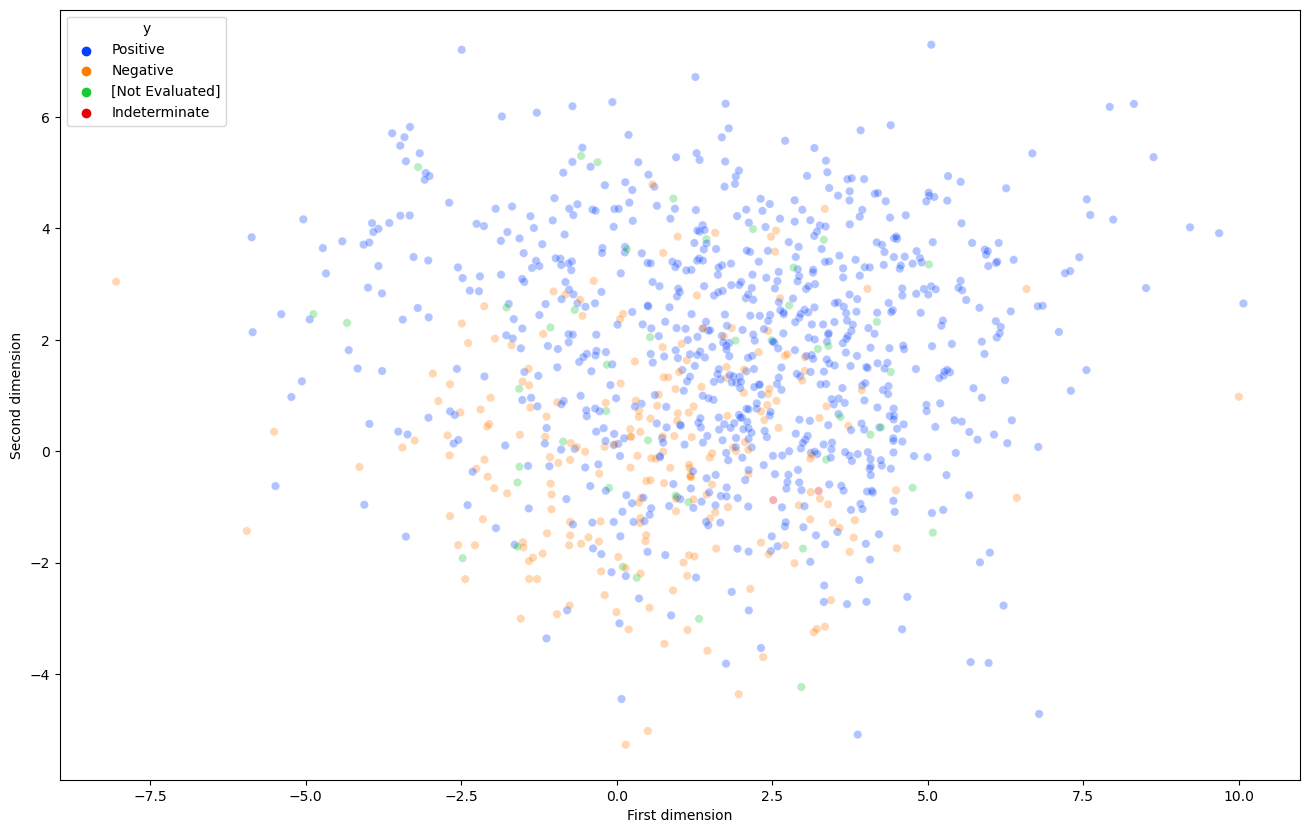

In [165]:
plotfm(model,data_gpu,ER,legend = "full",eps = NOISE)

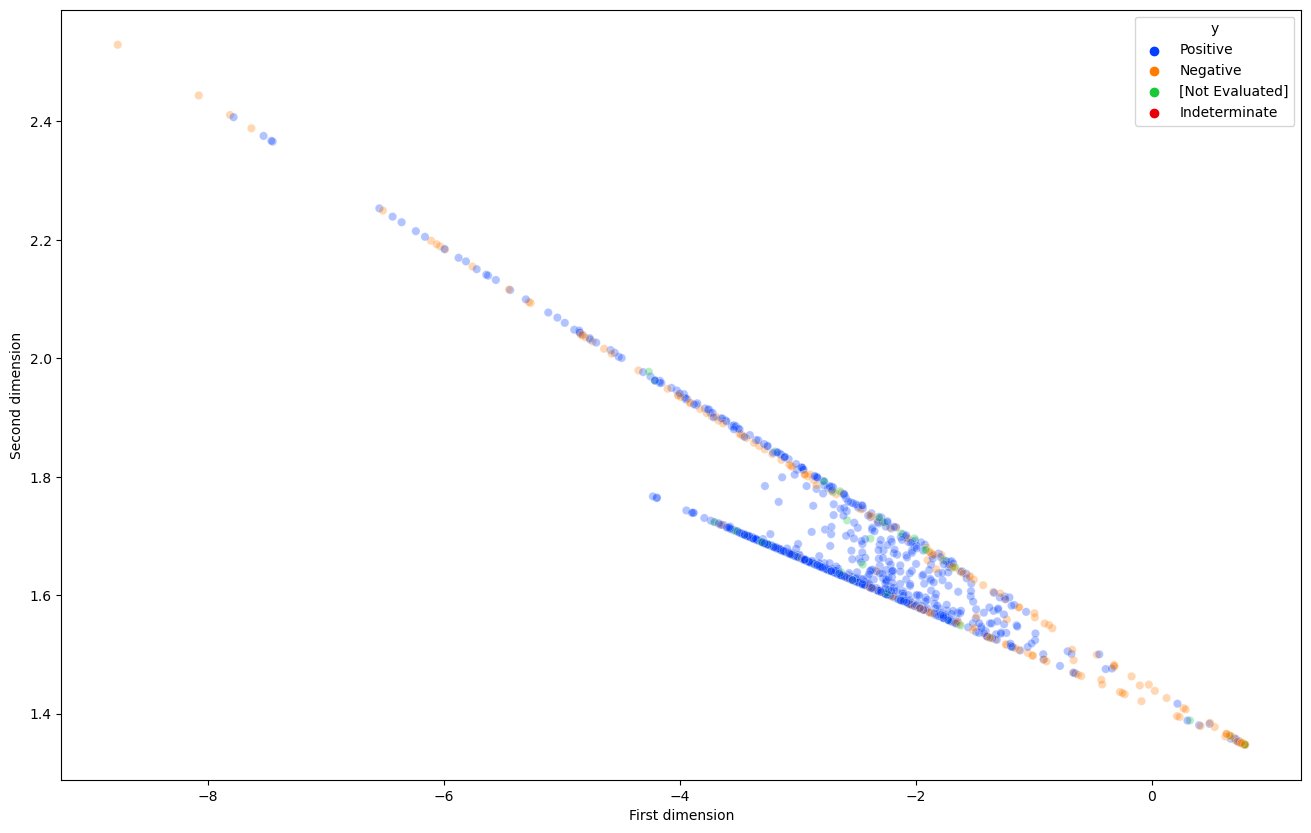

In [158]:
m, v = model.encoder(data_gpu)
plot(m.cpu().detach(),ER)
from matplotlib import pyplot as plt
plt.savefig('single_with_SNIS.png',dpi=300)